In [402]:
import pandas as pd
import datetime
import seaborn as sns
import math
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [403]:
shops = pd.read_csv('data/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [404]:
sales_train = pd.read_csv('data/sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [405]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [406]:
#formatting the date column correctly
sales_train['date']=pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

In [407]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [408]:
sales_train.shape

(2935849, 6)

In [409]:
sales_train = sales_train[sales_train['item_cnt_day']>0]
sales_train.shape

(2928493, 6)

In [410]:
sales_train.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [411]:
item_categories = pd.read_csv('data/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [412]:
items = pd.read_csv('data/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [413]:
sales_groupped = sales_train.groupby(['shop_id', 'date']).count()[['item_id']].rename(columns={'item_id':'count'}).reset_index()

In [414]:
sales_groupped.head()

,shop_id,date,count
0,0,2013-01-03,174
1,0,2013-01-04,272
2,0,2013-01-05,236
3,0,2013-01-06,177
4,0,2013-01-07,116


In [415]:
sales_group_by_shop = sales_groupped.groupby('shop_id').count()[['date']].rename(columns={'date':'num_days'}).reset_index()
sales_group_by_shop.head()

,shop_id,num_days
0,0,57
1,1,56
2,2,1018
3,3,1028
4,4,1010


In [416]:
shops_sorted = pd.merge(shops, sales_group_by_shop, on=['shop_id'])

In [417]:
shops_sorted.head()

,shop_name,shop_id,num_days
0,"!Якутск Орджоникидзе, 56 фран",0,57
1,"!Якутск ТЦ ""Центральный"" фран",1,56
2,"Адыгея ТЦ ""Мега""",2,1018
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1028
4,"Волжский ТЦ ""Волга Молл""",4,1010


In [418]:
shops_sorted = shops_sorted.sort_values(by=['num_days'], ascending=False).reset_index(drop=True)

In [419]:
shops_sorted

,shop_name,shop_id,num_days
0,"Воронеж ТРЦ ""Максимир""",7,1034
1,"Омск ТЦ ""Мега""",38,1034
2,"СПб ТК ""Невский Центр""",42,1033
3,"Н.Новгород ТРЦ ""Фантастика""",35,1033
4,"Калуга ТРЦ ""XXI век""",15,1033
5,"Сергиев Посад ТЦ ""7Я""",46,1032
6,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,1032
7,"Ярославль ТЦ ""Альтаир""",59,1032
8,"Уфа ТЦ ""Семья"" 2",53,1031
9,"Москва ТЦ ""Семеновский""",31,1031


In [420]:
assert shops_sorted[shops_sorted['shop_id']==20]['num_days'].iloc[0] == len(sales_train[sales_train['shop_id']==20].groupby(['date']).groups.keys())

### Preparaing data in the notebook, in the web app the data should come in needed format already 

In [421]:
#data = sales_train[sales_train['shop_id']==7].drop(columns=['shop_id', 'date_block_num']).reset_index(drop=True)
data = sales_train[~sales_train['shop_id'].isin(['43,7,8']) ].drop(columns=['date_block_num']).reset_index(drop=True)
data = pd.merge(data, items, on=['item_id'], how='left')
data.shape

(57977, 6)

### Check the data for format and having 6 month of records 

### Filter data

In [469]:
data = data[data['item_cnt_day']>0]
data = data[data['item_price']>0]
data = data.dropna()

In [470]:
data.head()

,date,item_id,item_price,item_cnt_day,item_name,item_category_id,month,year
0,2013-01-09,2441,1199.0,1.0,"Crysis 2 [Xbox 360, русская версия]",23,1,2013
1,2013-01-06,2241,399.0,1.0,CUTUGNO TOTO Maestro Collection 2CD,55,1,2013
2,2013-01-05,2678,999.0,1.0,Dance Central 2 - MSX Xbox 360 Russian Russia ...,23,1,2013
3,2013-01-07,2703,599.0,1.0,"Dark Souls: Prepare to Die Edition [PC, Jewel,...",30,1,2013
4,2013-01-17,2703,599.0,1.0,"Dark Souls: Prepare to Die Edition [PC, Jewel,...",30,1,2013


### Add month and year and aggregate data

In [471]:
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data.head()

,date,item_id,item_price,item_cnt_day,item_name,item_category_id,month,year
0,2013-01-09,2441,1199.0,1.0,"Crysis 2 [Xbox 360, русская версия]",23,1,2013
1,2013-01-06,2241,399.0,1.0,CUTUGNO TOTO Maestro Collection 2CD,55,1,2013
2,2013-01-05,2678,999.0,1.0,Dance Central 2 - MSX Xbox 360 Russian Russia ...,23,1,2013
3,2013-01-07,2703,599.0,1.0,"Dark Souls: Prepare to Die Edition [PC, Jewel,...",30,1,2013
4,2013-01-17,2703,599.0,1.0,"Dark Souls: Prepare to Die Edition [PC, Jewel,...",30,1,2013


In [472]:
keep_columns_agg = ['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'month', 'year', 'item_category_id']
data_monthly = data[keep_columns_agg].groupby(['year','month', 'shop_id', 'item_category_id', 'item_id'], as_index=False).agg(
    {'item_price':'mean', 
     'item_cnt_day':['sum', 'mean'] })

data_monthly.columns = data_monthly.columns.map(''.join)
data_monthly = data_monthly.rename(columns={
    'item_pricemean': 'item_price_avg', 
    'item_cnt_daysum':'item_cnt_month',
    'item_cnt_daymean':'item_cnt_day_mean'})
data_monthly = data_monthly.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)
data_monthly.head()

,year,month,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
0,2013,1,40,32,349.0,1.0,1.0
1,2013,1,37,33,499.0,1.0,1.0
2,2013,1,40,35,399.0,1.0,1.0
3,2013,1,40,96,149.0,1.0,1.0
4,2013,1,40,98,399.0,4.0,1.0


In [473]:
data_monthly.describe()

,year,month,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
count,32693.000000,32693.000000,32693.000000,32693.000000,32693.000000,32693.000000,32693.00000
mean,2013.811428,6.173646,39.530542,10428.651302,845.980335,2.054232,1.04994
std,0.781110,3.476342,16.594345,6221.397838,1635.619269,4.730938,0.33699
min,2013.000000,1.000000,2.000000,27.000000,0.100000,1.000000,1.00000
25%,2013.000000,3.000000,28.000000,4812.000000,199.000000,1.000000,1.00000
50%,2014.000000,6.000000,40.000000,10077.000000,399.000000,1.000000,1.00000
75%,2014.000000,9.000000,55.000000,15811.000000,959.000000,2.000000,1.00000
max,2015.000000,12.000000,83.000000,22167.000000,35990.000000,317.000000,26.00000


In [474]:
data_monthly.shape

(32693, 7)

In [475]:
#item_global_mean = data_monthly.groupby(['item_id'])[['item_cnt_month']].mean().rename(columns={'item_cnt_month':'global_mean'})

In [476]:
#data_monthly = pd.merge(data_monthly, item_global_mean, on=['item_id'], how='left')
#data_monthly = data_monthly.sort_values(by=['year', 'month', 'item_id']).reset_index(drop=True)

In [477]:
#data_monthly.describe()

In [478]:
#data_monthly = data_monthly[data_monthly['global_mean'] > 3]
#data_monthly.shape

In [479]:
#data_monthly.describe()

In [480]:
#data_monthly[data_monthly['item_id'] == 471]

,year,month,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean


### Fill records with missing ones to have a complete data set 

In [481]:
# Build a data set with all the possible combinations to avoid having missing records.
item_ids = data_monthly['item_id'].unique()
shop_ids = data_monthly['shop_id'].unique()

start_date = data['date'].min()
end_date = data['date'].max()

start_month = start_date.month
start_year = start_date.year

number_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1

print(start_date)
print(end_date)
print('Number of months is {}'.format(number_of_months))

empty_df = []
cur_month = start_month
cur_year = start_year

for i in range(number_of_months):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([cur_month, cur_year, shop, item])
    
    add_12_if_receive_0 = (12 - 12*math.ceil((cur_month+1)%12 / 12))
    cur_month = (cur_month+1)%12 + add_12_if_receive_0
    
    if cur_month == 1:
        cur_year += 1
    
empty_df = pd.DataFrame(empty_df, columns=['year', 'month', 'shop_id', 'item_id'])

2013-01-01 00:00:00
2015-10-31 00:00:00
Number of months is 34


In [482]:
# missing records will be filled with 0s
data_monthly_ext = pd.merge(empty_df, data_monthly, on=['year','month', 'shop_id','item_id'], how='left')
data_monthly_ext.fillna(0, inplace=True)
data_monthly_ext = data_monthly_ext.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)

In [483]:
data_monthly_ext.head()

,month,year,item_id,item_category_id,item_price_avg,item_cnt_month,item_cnt_day_mean
0,1,2013,27,0.0,0.0,0.0,0.0
1,1,2013,28,0.0,0.0,0.0,0.0
2,1,2013,29,0.0,0.0,0.0,0.0
3,1,2013,30,0.0,0.0,0.0,0.0
4,1,2013,31,0.0,0.0,0.0,0.0


In [484]:
# add date_block to split data into train and test
data_monthly_ext['date_block_num'] = data_monthly_ext.apply(lambda row: (row['year']*12 + row['month'])- (start_year*12 + start_month), axis=1)

In [485]:
#data_monthly_ext[data_monthly_ext['item_id'] == 471]

,month,year,item_id,item_category_id,item_price_avg,item_cnt_month,item_cnt_day_mean,date_block_num


### Feature engineering 

In [486]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    data_monthly_ext[('item_cnt_roll_%s' % function_name[i])] = data_monthly_ext.groupby(['shop_id','item_id'])['item_cnt_month'].apply(function_list[i])

# Fill the empty std features with 0
data_monthly_ext['item_cnt_roll_std'].fillna(0, inplace=True)

In [487]:
data_monthly_ext['item_mean_past'] = data_monthly_ext.groupby(['shop_id', 'item_category_id'])[['item_cnt_month']].expanding().mean().values

In [488]:
data_monthly_ext['category_mean_past'] = data_monthly_ext.groupby(['shop_id', 'item_id'])[['item_cnt_month']].expanding().mean().values

In [489]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    data_monthly_ext[ft_name] = data_monthly_ext.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    data_monthly_ext[ft_name].fillna(0, inplace=True)

In [490]:
data_monthly_ext['item_trend'] = data_monthly_ext['item_cnt_month']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    data_monthly_ext['item_trend'] -= data_monthly_ext[ft_name]

data_monthly_ext['item_trend'] /= len(lag_list) + 1

In [491]:
data_monthly_ext.head()

,month,year,item_id,item_category_id,item_price_avg,item_cnt_month,item_cnt_day_mean,date_block_num,item_cnt_roll_min,item_cnt_roll_max,item_cnt_roll_mean,item_cnt_roll_std,item_mean_past,category_mean_past,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,1,2013,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2013,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2013,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2013,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2013,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create labels that we will be predicting - number of items sold next month

In [492]:
data_monthly_ext['itm_cnt_nxt_mnth'] = data_monthly_ext.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(-1)
data_monthly_ext.head()

,month,year,item_id,item_category_id,item_price_avg,item_cnt_month,item_cnt_day_mean,date_block_num,item_cnt_roll_min,item_cnt_roll_max,item_cnt_roll_mean,item_cnt_roll_std,item_mean_past,category_mean_past,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,itm_cnt_nxt_mnth
0,1,2013,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2013,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2013,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2013,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,1,2013,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [493]:
data_monthly_ext.shape

(280364, 19)

In [494]:
# calculate date_block_num for splitting
num_months = data_monthly_ext['date_block_num'].max() + 1
train_low = 3
train_high = int(0.7 * num_months)
validate_high = num_months - 1

### Split data into train, validate, test. Test - the actual prediction for which we don't have the real data 

In [495]:
train_set = data_monthly_ext.query('date_block_num >= @train_low and date_block_num <= @train_high').copy()
validation_set = data_monthly_ext.query('date_block_num > @train_high and date_block_num < @validate_high').copy()
test_set = data_monthly_ext.query('date_block_num == @validate_high').copy()

train_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)
validation_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/data_monthly_ext.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/data_monthly_ext.shape[0])*100)))

Train set records: 173166
Validation set records: 74214
Test set records: 8246
Train set records: 173166 (62% of complete data)
Validation set records: 74214 (26% of complete data)


### More feature engineering done on each train, validate to avoid data leakage 

In [496]:
# create functions for creating mean encoding

In [497]:
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_item_mean.columns = ['item_mean_future']
gp_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_year_mean.columns = ['year_mean_future']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_month_mean.columns = ['month_mean_future']
gp_month_mean.reset_index(inplace=True)
# Category mean encoding.
gp_category_mean = train_set.groupby(['item_category_id']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_category_mean.columns = ['category_mean_future']
gp_category_mean.reset_index(inplace=True)
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean_future']
gp_shop_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean_future']
gp_shop_item_mean.reset_index(inplace=True)


# Add mean encoding features to train set.
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
train_set = pd.merge(train_set, gp_category_mean, on=['item_category_id'], how='left')
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')

# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')
validation_set = pd.merge(validation_set, gp_category_mean, on=['item_category_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')


In [498]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
Y_train = train_set['itm_cnt_nxt_mnth'].astype(int)
X_validation = validation_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
Y_validation = validation_set['itm_cnt_nxt_mnth'].astype(int)

In [499]:
# Create a test set

In [500]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['item_id'], keep='last')
X_test = pd.merge(test_set, latest_records, on=['item_id'], how='left', suffixes=['', '_'])
X_test.drop('itm_cnt_nxt_mnth', axis=1, inplace=True)
X_test = X_test[X_train.columns]
X_test.head()

,month,year,item_id,item_category_id,item_price_avg,item_cnt_month,item_cnt_day_mean,item_cnt_roll_min,item_cnt_roll_max,item_cnt_roll_mean,...,category_mean_past,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,item_mean_future,year_mean_future,month_mean_future,category_mean_future,shop_mean_future
0,10,2015,27,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.058824,0.0,0.0,0.0,0.0,0.047619,NaN,0.235993,0.121848,0.264567
1,10,2015,28,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.055556,0.0,0.0,0.0,0.0,0.047619,NaN,0.235993,0.121848,0.264567
2,10,2015,29,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.052632,0.0,0.0,0.0,0.0,0.047619,NaN,0.235993,0.121848,0.264567
3,10,2015,30,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.050000,0.0,0.0,0.0,0.0,0.571429,NaN,0.235993,0.121848,0.264567
4,10,2015,31,0.0,0.0,0.0,0.0,0.0,2.0,0.666667,...,0.047619,0.0,0.0,0.0,0.0,0.095238,NaN,0.235993,0.121848,0.264567


In [501]:
#X_train.drop(['item_category_id'], axis=1, inplace=True)
#X_validation.drop(['item_category_id'], axis=1, inplace=True)
#X_test.drop(['item_category_id'], axis=1, inplace=True)

In [502]:
# Use only part of features on XGBoost.
xgb_features = ['month_mean_future', 'year_mean_future', 'item_mean_future', 'shop_mean_future',' shop_item_mean_future', 'category_mean_future',
                'category_mean_past', 'item_mean_past', 
                'item_cnt_month', 'item_cnt_day_mean', 
                'item_cnt_roll_mean', 'item_cnt_roll_std', 
                'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3', 
                'item_trend', 'month']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [503]:
xgb_model = XGBRegressor()
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[22:44:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.89386	validation_1-rmse:1.19113
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:1.04409	validation_1-rmse:0.935805
Stopping. Best iteration:
[11]	validation_0-rmse:1.2045	validation_1-rmse:0.893251



XGBRegressor()

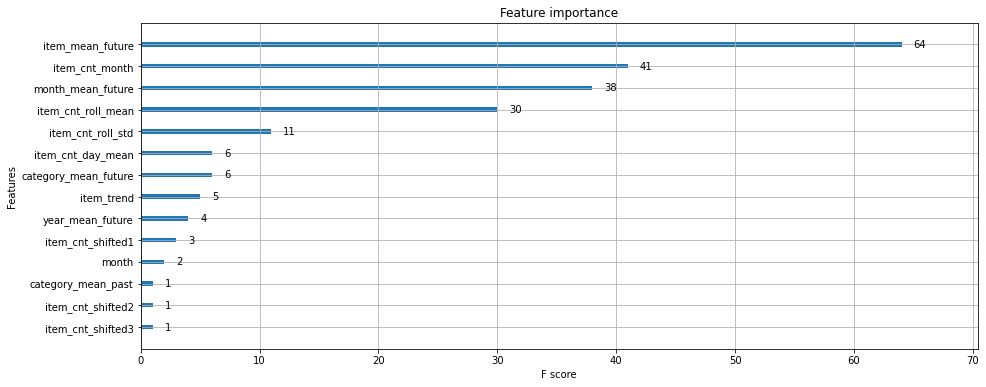

In [504]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [505]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
#xgb_test_pred = xgb_model.predict(xgb_test)

In [506]:
# cast predictions to integer to make them useful in real world
xgb_train_pred = xgb_train_pred.astype(int)

In [507]:
xgb_val_pred = xgb_val_pred.astype(int)

In [508]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 1.241538121171115
Validation rmse: 0.8919742582898308


In [509]:
print('Train MAE:', mean_absolute_error(Y_train, xgb_train_pred))
print('Validation MAE:',mean_absolute_error(Y_validation, xgb_val_pred))

Train MAE: 0.2259739209775591
Validation MAE: 0.1515078017624707


In [510]:
validate_act_vs_pred = pd.DataFrame(zip(Y_validation, xgb_val_pred), columns=['actual', 'prediction'])

In [511]:
validate_non_zero = validate_act_vs_pred[validate_act_vs_pred['actual'] != 0]

In [512]:
print('Validation MAE on non-zero values:',mean_absolute_error(validate_non_zero['actual'], validate_non_zero['prediction']))

Validation MAE on non-zero values: 1.5706214689265536


In [513]:
y_true = np.array(validate_non_zero['actual'])
y_pred = np.array(validate_non_zero['prediction'])
np.mean(np.abs((y_true - y_pred) / y_true)) * 100

90.72208844740125

In [514]:
#X = data_monthly_ext.drop(columns=['itm_cnt_nxt_mnth'])

In [515]:
#y = data_monthly_ext[['itm_cnt_nxt_mnth']]